<a href="https://colab.research.google.com/github/Ezra-A-Cohen/inspirit-AI/blob/main/09_Planet_Hunters_Notebook_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I will work on finnishing the process of fixing this notebook up at some later point, currently the only thing that is still using outdated packages is the code for the confusion matrices

# Classifying Exoplanets

In this notebook, we'll continue improving our models for exoplanet classification!

We'll be:
*   Preprocessing the Dataset similar to before
*   Implementing more modern and complex machine learning architectures to see which one performs best!

## Exoplanet Classification




Previously, we were able to visualize and augment the dataset from Kepler. Now that we better understand the data that we're working with, we can begin to dive into more complex architectures to classify exoplanet stars, and the difficulties faced when doing so.

**IMPORTANT**: Make sure you've got 'Change Runtime Type' set to **GPU**!

In [2]:
#@title Run this code to get started
%tensorflow_version 2.x
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv'

from urllib.request import urlretrieve
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn import  metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.signal import savgol_filter
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,plot_confusion_matrix,precision_score,recall_score,f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, BatchNormalization, MaxPooling1D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.python.keras.engine

df_train = pd.read_csv('exoTrain.csv')
df_train.LABEL = df_train.LABEL -1
df_test = pd.read_csv('exoTest.csv')
df_test.LABEL = df_test.LABEL - 1

def plot_graphs(history, best):
  
  plt.figure(figsize=[10,4])
  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy across training\n best accuracy of %.02f'%best[1])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  
  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss across training\n best loss of %.02f'%best[0])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def analyze_results(model, train_X, train_y, test_X, test_y):
    """
    Helper function to help interpret and model performance.
    
    Args:
    model: estimator instance
    train_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model training.
    train_y : array-like of shape (n_samples,)
    Target values for model training.
    test_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model testing.
    test_y : array-like of shape (n_samples,)
    Target values for model testing.

    Returns:
    None
    """
    print("-------------------------------------------")
    print("Model Results")
    print("")
    print("Training:")
    if type(model) == keras.engine.sequential.Sequential:
      train_predictions = model.predict(train_X)
      train_predictions = (train_predictions > 0.5)
      cm = confusion_matrix(train_y, train_predictions)
      labels = [0, 1]
      df_cm = pd.DataFrame(cm,index = labels,columns = labels)
      fig = plt.figure()
      res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
      #plt.yticks([1.25, 3.75], labels,va='center')
      plt.title('Confusion Matrix - TestData')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
    else:
      fig = plt.figure(figsize=(22,7))
      ax = fig.add_subplot(1,3,1)
      plot_confusion_matrix(model,train_X,train_y,ax=ax,values_format = '.0f')
      plt.show()
    print("Testing:")
    if type(model) == keras.engine.sequential.Sequential:
      test_predictions = model.predict(test_X)
      test_predictions = (test_predictions > 0.5)
      cm = confusion_matrix(test_y, test_predictions)
      labels = [0, 1]
      df_cm = pd.DataFrame(cm,index = labels,columns = labels)
      fig = plt.figure()
      res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
      #plt.yticks([1.25, 3.75], labels,va='center')
      plt.title('Confusion Matrix - TestData')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
    else:
      fig = plt.figure(figsize=(22,7))
      ax = fig.add_subplot(1,3,1)
      plot_confusion_matrix(model,test_X,test_y,ax=ax,values_format = '.0f')
      plt.show()

def reset(train,test):
    train_X = train.drop('LABEL', axis=1)
    train_y = train['LABEL'].values
    test_X = test.drop('LABEL', axis=1)
    test_y = test['LABEL'].values
    return train_X,train_y,test_X,test_y

train_X,train_y,test_X,test_y = reset(df_train, df_test)

--2022-02-21 02:41:29--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 64.233.182.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262223348 (250M) [application/octet-stream]
Saving to: ‘exoTrain.csv’

exoTrain.csv        100%[===================>] 250.08M  89.5MB/s    in 2.8s    

2022-02-21 02:41:32 (89.5 MB/s) - ‘exoTrain.csv’ saved [262223348/262223348]

--2022-02-21 02:41:32--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 209.85.146.128, 142.250.125.128, ...
Connecting to storage.googleapis

Remember that `df_train` and `df_test` are the Pandas data frames that store our training and test datapoints. Similar to before, we'll now augment the data before exploring more modern, complex machine learning architectures.

In [3]:
#@title Run this code to preprocess data
# Helper functions that we can run for the three augmentation functions that will be used, but not explroed in depth

def smote(a,b):
    model = SMOTE()
    X,y = model.fit_resample(a, b)
    return X,y

def savgol(df1,df2):
    x = savgol_filter(df1,21,4,deriv=0)
    y = savgol_filter(df2,21,4,deriv=0)
    return x,y

def fourier(df1,df2):
    train_X = np.abs(np.fft.fft(df1, axis=1))
    test_X = np.abs(np.fft.fft(df2, axis=1))
    return train_X,test_X

def norm(df1,df2):
    train_X = normalize(df1)
    test_X = normalize(df2)
    return train_X,test_X

def robust(df1,df2):
    scaler = RobustScaler()
    train_X = scaler.fit_transform(df1)
    test_X = scaler.transform(df2)
    return train_X,test_X

fourier_train_X, fourier_test_X = fourier(train_X, test_X)
savgol_train_X, savgol_test_X = savgol(fourier_train_X, fourier_test_X)
norm_train_X, norm_test_X = norm(savgol_train_X,savgol_test_X)
robust_train_X, robust_test_X = robust(norm_train_X, norm_test_X)
smote_train_X,smote_train_y = smote(robust_train_X, train_y)

# Here we're adding the generated, augmented data onto the testing data
aug_train_X, new_X_test_data, aug_train_y, new_y_test_data = train_test_split(smote_train_X, smote_train_y, test_size=0.3)
aug_test_X = np.concatenate((robust_test_X, new_X_test_data), axis=0)
aug_test_y = np.concatenate((test_y, new_y_test_data), axis=0)


Awesome! Now we'll have access to the augmented dataset as `aug_train_X`, `aug_text_X`, `aug_train_y`, and `aug_test_y`. 

(For further exploration and model comparison based off different datasets, you can explore the code block from above to access the different versions of the augmented data. For instance, what happens if we use the raw data? Normalized data?)

## Milestone 1: MLP

Let's start with neural nets!

MLP stands for Multi-layer Perceptron, a specific kind of simple neural network. Thankfully, this is something that Sklearn supports, and it's already imported as MLPClassifier. 


![visual](https://s3.amazonaws.com/stackabuse/media/intro-to-neural-networks-scikit-learn-3.png)

#### Step 1: Create our model

Let's complete this by using a `MLPClassifier` model imported by the sklearn package. You can view the original documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). Let's create a model with:
1. One hidden layer with 10 units
2. random_state = 1
3. 300 max iterations

In [4]:
# Create an MLP model (will train later)

model = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(10))  # YOUR CODE HERE

Now, train your model using `aug_train_X` and `aug_train_y`, and analyze its accuracy and confusion matrix!

You have access to all the methods used in the previous notebook.

In [5]:
model.fit(aug_train_X, aug_train_y)
train_predictions = model.predict(aug_train_X)
test_predictions = model.predict(aug_test_X)
print(accuracy_score(aug_train_y, train_predictions))
print(accuracy_score(aug_test_y, test_predictions))
analyze_results(model=model, train_X=aug_train_X, train_y=aug_train_y, test_X=aug_test_X, test_y=aug_test_y)

1.0
0.9963888888888889
-------------------------------------------
Model Results

Training:


AttributeError: ignored

**Discuss:** Were the results what you were expecting? Why or why not? How does it compare with past model results?

What might be any potential issues that we might run into?

**Hint:** What are some downsides to a traditional MLP? What would happen if we shifted the data left or right?

## Milestone 2: Neural Networks (Tensorflow and Keras)

Now let's do what we did before, but using `tensorflow` and `keras`. These libraries will be crucial as they will allow us to create more complex models. 

We'll start by creating a similar model using these new packages. 

We'll be using a `Sequential` model in order to act as a "list of layers", which we will define to match our previous example. Later, we'll use it to build more complex, advanced models. More information can be found [here](https://keras.io/api/layers/).

1. Add a `Dense` layer with 10 hidden units and a ReLU activation function. This layer also requires an `input_shape` parameter. What should the input shape be?

2. Add a `Dense` layer with 1 hidden unit and a sigmoid activation function. (This will be our output layer)

**Discuss:** Why is there only 1 neuron in the final layer? Why do we have two layers?

In [6]:
# Create a model (will train later)

# First, we initialize our model
model = Sequential()
model.add(Dense(10, input_shape=(3197,), activation = "relu"))
model.add(Dense(1, activation = 'sigmoid'))

# we finalize the model by "compiling" it and defining some other hyperparameters 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now to check the details of your model, run the code block below.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                31980     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31,991
Trainable params: 31,991
Non-trainable params: 0
_________________________________________________________________


Now train and analyze your `model` like you did before! You'll need to specify these parameters to `fit`:

1. `batch_size` = 64
2. `epochs` = 20
3. `verbose` = 1
4. `validation_data` = (aug_test_X, aug_test_y)
5. `shuffle` = True

Save the history of the model as it trains or "fits" the data.



In [8]:
history = model.fit(aug_train_X, aug_train_y, batch_size=64, epochs=20, verbose=1, validation_data=(aug_test_X, aug_test_y), shuffle=True)

Epoch 1/20
111/111 [==============================] - 8s 18ms/step - loss: 0.1788 - accuracy: 0.9272 - val_loss: 0.0654 - val_accuracy: 0.9842
Epoch 2/20
111/111 [==============================] - 1s 11ms/step - loss: 0.0477 - accuracy: 0.9867 - val_loss: 0.0482 - val_accuracy: 0.9850
Epoch 3/20
111/111 [==============================] - 1s 11ms/step - loss: 0.0268 - accuracy: 0.9936 - val_loss: 0.0889 - val_accuracy: 0.9733
Epoch 4/20
111/111 [==============================] - 1s 11ms/step - loss: 0.0240 - accuracy: 0.9922 - val_loss: 0.0336 - val_accuracy: 0.9900
Epoch 5/20
111/111 [==============================] - 1s 11ms/step - loss: 0.0172 - accuracy: 0.9948 - val_loss: 0.0599 - val_accuracy: 0.9853
Epoch 6/20
111/111 [==============================] - 1s 12ms/step - loss: 0.0192 - accuracy: 0.9934 - val_loss: 0.0282 - val_accuracy: 0.9936
Epoch 7/20
111/111 [==============================] - 1s 11ms/step - loss: 0.0176 - accuracy: 0.9936 - val_loss: 0.0438 - val_accuracy: 0.9825

Now we will see how to view the performance of the model as it trained over time!

In addition, we still want to be able to plot the confusion matrix of the model to check for performance and potential class biases. Enter code to analyze the model in the empty portion of the codeblock below.

57/57 [==============================] - 0s 3ms/step - loss: 0.0325 - accuracy: 0.9911


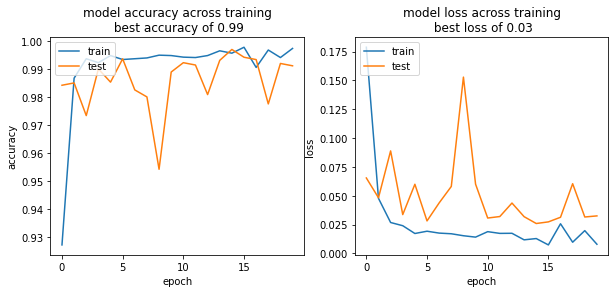

-------------------------------------------
Model Results

Training:


AttributeError: ignored

In [9]:
performance = model.evaluate(aug_test_X, aug_test_y, batch_size=64)
plot_graphs(history, performance)
analyze_results(model=model, train_X=aug_train_X, train_y=aug_train_y, test_X=aug_test_X, test_y=aug_test_y)

## Milestone 3: Covolutional Neural Network (CNN)

One potential fault of our previous approach is memorizing the placement of specific patterns in the data. Although we were able to achieve great levels of accuracy, we might benefit from an architecture that can make decisions based on patterns no matter where they occur in the sample - for example, if we started measuring flux earlier or later! 

This is something that CNNs excel at. Most CNN architectures are set up to work with two dimensional inputs such as images, so our approach will be a bit different in working with and creating a one-dimensional CNN. However, similar concepts apply as we'll be passing a filter accoss the each data point with respect to time.

[Here](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) is a link to learn more about convolutional neural nets, and [here's](https://poloclub.github.io/cnn-explainer/) an interactive demo to explore. Try talking through the image of a traditional CNN below!

![](https://miro.medium.com/max/3288/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

First, we'll have to "reshape" our augmented data into a shape that can be fed into a 1-dimensional CNN. We've reshaped the training data below - please **reshape the testing data, too.**

Note: No new information is created, but just the way the information is structured. Because of this, we should have the same number of values present overall with no modifications to the values themselves.

In [10]:
cnn_aug_train_X = np.expand_dims(aug_train_X, axis=2)
cnn_aug_test_X = np.expand_dims(aug_test_X, axis=2)
cnn_aug_train_y = aug_train_y
cnn_aug_test_y = aug_test_y
 
cnn_train_X = np.expand_dims(train_X, axis=2)
cnn_test_X = np.expand_dims(test_X, axis=2)
cnn_train_y = train_y
cnn_test_y = test_y

What are the new shapes of the data? The new data is stored in variables: `cnn_aug_train_X`, `cnn_aug_test_X`, `cnn_aug_train_y`, `cnn_aug_test_y`.

In [11]:
print(cnn_aug_train_X.shape)
print(cnn_aug_test_X.shape)
print(cnn_aug_train_y.shape)
print(cnn_aug_test_y.shape)

(7070, 3197, 1)
(3600, 3197, 1)
(7070,)
(3600,)


Awesome!

Now, we'll be using a `Sequential` model to build up our CNN. Here's a suggestion for an architecture to start with:

1. Add a `Conv1D` layer with 8 output filters, kernal size of 5, relu activation function, and padding = 'same'. This layer also requires an `input_shape` parameter. Does the defined input_shape make sense?

2. Add a `MaxPooling1D` layer with pool_size = 4, strides = 4, and padding = 'same'.

3. Add a `Conv1D` layer with 16 output filters, kernal size of 3, relu activation function, and padding = 'same'. 

4. Add a `MaxPooling1D` layer with pool_size = 4, strides = 4, and padding = 'same'.

5. Add a `Flatten` layer.

6. Add a `Dense` layer with 1 hidden unit and a sigmoid activation function. (This will be our output layer)

Discuss: Why is there only 1 neuron in the final layer? Why do we have the same loss function and metrics as the network before if we're using two different architectures?

In [12]:
# Create model

# First, we initialize our model
model = Sequential()
input_shape = [3197, 1]

cnn_layer_1 = Conv1D(8, 5, activation='relu', input_shape=input_shape, padding='same')
cnn_layer_2 = MaxPooling1D(pool_size=4, strides=4, padding='same')
cnn_layer_3 = Conv1D(16, 3, activation='relu', padding='same')
cnn_layer_4 = MaxPooling1D(pool_size=4, strides=4, padding='same')
cnn_layer_5 = Flatten()
cnn_layer_6 = Dense(1, activation='sigmoid')
 
# then we add a "Dense" (i.e. fully connected) layer
model.add(cnn_layer_1)
model.add(cnn_layer_2)
model.add(cnn_layer_3)
model.add(cnn_layer_4)
model.add(cnn_layer_5)
model.add(cnn_layer_6)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now train the model like we did before! (Make sure to use the newly formatted data instead. This will include `cnn_aug_train_X`, `cnn_aug_test_X`, `cnn_aug_train_y`, and `cnn_aug_test_y`)

In [14]:
# Train the Model

history = model.fit(cnn_aug_train_X, cnn_aug_train_y, batch_size=64, epochs=20, verbose=1, 
                            validation_data=(cnn_aug_test_X, cnn_aug_test_y), shuffle=True)


Epoch 1/20
111/111 [==============================] - 10s 16ms/step - loss: 0.2869 - accuracy: 0.8878 - val_loss: 0.1130 - val_accuracy: 0.9719
Epoch 2/20
111/111 [==============================] - 1s 12ms/step - loss: 0.0746 - accuracy: 0.9818 - val_loss: 0.0702 - val_accuracy: 0.9831
Epoch 3/20
111/111 [==============================] - 1s 13ms/step - loss: 0.0412 - accuracy: 0.9909 - val_loss: 0.0713 - val_accuracy: 0.9808
Epoch 4/20
111/111 [==============================] - 1s 13ms/step - loss: 0.0289 - accuracy: 0.9928 - val_loss: 0.0520 - val_accuracy: 0.9814
Epoch 5/20
111/111 [==============================] - 1s 13ms/step - loss: 0.0231 - accuracy: 0.9938 - val_loss: 0.0321 - val_accuracy: 0.9928
Epoch 6/20
111/111 [==============================] - 2s 21ms/step - loss: 0.0168 - accuracy: 0.9956 - val_loss: 0.0293 - val_accuracy: 0.9947
Epoch 7/20
111/111 [==============================] - 2s 23ms/step - loss: 0.0155 - accuracy: 0.9953 - val_loss: 0.0295 - val_accuracy: 0.993

Once again, let's analyze the model's performance over time and the final confusion matrices:

In [15]:
analyze_results(model=model, train_X=aug_train_X, train_y=aug_train_y, test_X=aug_test_X, test_y=aug_test_y)

-------------------------------------------
Model Results

Training:


AttributeError: ignored

#### (Optional) Exercise

How does the model perform with different amount of layers and different amount of neurons within each layer? How does the same model perform of the original dataset? (`cnn_train_X`, `cnn_test_X`, `cnn_train_y`, `cnn_test_y`, these are the same original values but resized to work with the new architecture) How does it perform when trained on the original dataset?

**Hint:** Try out new layers like a "Dropout" layer. More complex architectures often lead to better results as well. Try increasing the number of channels in each convolution layer or adding more layers in general!

57/57 [==============================] - 0s 6ms/step - loss: 0.0428 - accuracy: 0.9922


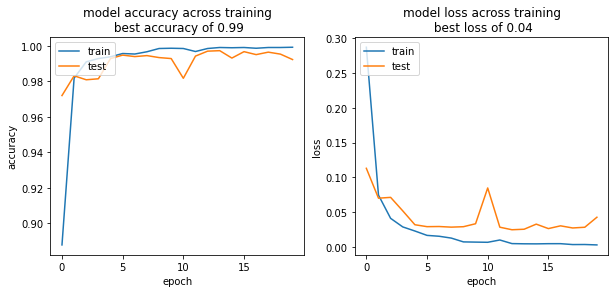

-------------------------------------------
Model Results

Training:


AttributeError: ignored

In [16]:
performance = model.evaluate(cnn_aug_test_X, cnn_aug_test_y, batch_size=64)
plot_graphs(history, performance)
 
 
analyze_results(model=model, train_X=cnn_aug_train_X, train_y=cnn_aug_train_y, test_X=cnn_aug_test_X, test_y=cnn_aug_test_y)

## Milestone 4: Optional Exploration


Congratulations! You've learned to visually analyze and refine raw satellite data, and built a top-of the line model that accurately detects exoplanet stars vs. non-exoplanet stars. This is critical to exoplanet hunting because it allows planetary hunters to focus on studying the exoplanets we've discovered, and analyzing them for mass, habitability, etc.

Remember that in our original dataset, exoplanet stars accounted for less than 1 % of all samples collected. In notebooks 2 and 3, we used machine learning to automatically identify likely exoplanet stars, dramatically reducing the time and effort needed to find them!

This pipeline can be used to help aid the search of exoplanets for the incoming, raw data. It might even lead to new planetary discoveries as space exploration continues! Try exploring more raw, unprocessed NASA data [here](https://www.nasa.gov/kepler/education/getlightcurves).

Of course, the more data, the better. This model and pipeline can be further improved with future iterations of new data and architectures. If you decide to go planet hunting, have fun on your new adventure!

**Optional**

Modify past model architectures or create new ones! See how they perform with the augmented dataset vs the original dataset! We can even explore different pre-processing techniques to help imporve the quality of our data! How will the new models, modifications, or pre-processing techniques compare to our past results? Which is the best solution?

**Hint**

If looking for inspiration, go to Tensorflow and check out different kinds of layers and activation functions! You can find the original documentation [here](https://keras.io/api/layers/).